In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from fastai.basics import set_seed
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *
from fastrenewables.tabular.model import EmbeddingModule

import torch.nn.functional as F

#import glob

In [3]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x_cat, x_cont):
        z = self.gan.noise(x_cont)
        fake_samples = self.gan.generator(x_cat, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, lr=1e-3, plot_epochs=10, save_model=False):
        
        self.gan.to_device(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        self.gan.gen_optim.param_groups[0]['lr'] = lr
        self.gan.dis_optim.param_groups[0]['lr'] = lr
        
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.gan.device).long()
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            if (e+1)%plot_epochs==0:
                plt.figure()
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                if len(self.gan.aux_loss) > 0:
                    plt.plot(self.gan.aux_loss, label='Aux Loss')
                plt.legend()
                plt.show()
        
        if save_model:
            self.gan.to_device('cpu')
        
        return

### Examples:

In [4]:
set_seed(1337)

n_samples = 1024*10
n_classes = 2
n_features = 1
batch_size = 1024
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 10
lr = 5e-5
n_gen = 1
n_dis = 1
aux_factor = 1

data = GaussianDataset(n_samples, n_classes)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

emb = EmbeddingModule(categorical_dimensions=[n_classes+1])

model = get_gan_model(gan_type='aux', structure=[n_z, n_hidden, n_hidden, n_in], n_classes=n_classes, emb_module=emb, bn=True, aux_factor=aux_factor)
print(model)

learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)

GAN(
  (generator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(3, 3)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=13, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
      )
      (3): Sigmoid()
    )
  )
  (discriminator): AuxiliaryDiscriminator(
    (basic_discriminator): GANMLP(
      (model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): Sequential(
       

 90%|█████████ | 9/10 [00:03<00:00,  3.14it/s]

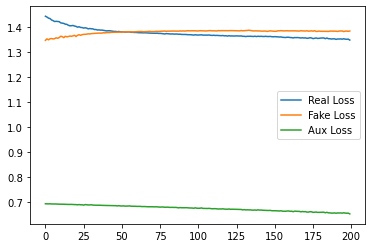

100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


distribution of real data:


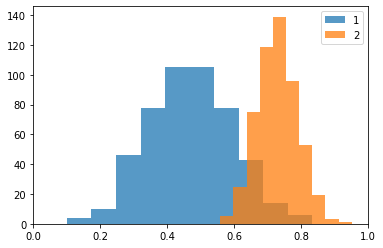

distribution of generated data:


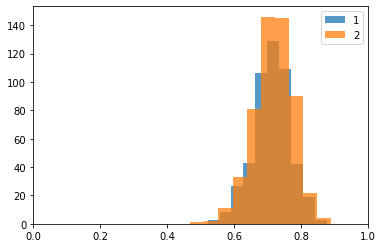

tensor(316.9567)

In [5]:
learner.fit(dl, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)

for x_cat, x_cont, y in dl:
    x_fake = learner.generate_samples(x_cat.long(), x_cont)

    print('distribution of real data:')
    plot_class_hists(x_cat, x_cont)

    print('distribution of generated data:')
    plot_class_hists(x_cat, x_fake.detach())
    break

real_d = torch.distributions.Normal(x_cont.mean(), x_cont.var()).log_prob(torch.linspace(0, 1, 1000))
fake_d = torch.distributions.Normal(x_fake.mean(), x_fake.var()).log_prob(torch.linspace(0, 1, 1000))

pq = F.kl_div(real_d, fake_d, reduction='batchmean', log_target=True)
qp = F.kl_div(fake_d, real_d, reduction='batchmean', log_target=True)

kl_div = (pq+qp)/2
kl_div